# Fish Classification - End to End Workflow

Proyek ini membangun sistem klasifikasi ikan menggunakan **time series contour** dengan **K-Nearest Neighbors (KNN)**.

## Workflow:
1. **Fase 1**: Training Model dari data .arff
2. **Fase 2**: Image Processing Pipeline (gambar → time series)
3. **Fase 3**: Deployment dengan Streamlit

Dataset: UCR Time Series - Fish Outlines

---
## FASE 1: Training Model (Backend)
### 1.1 Import Libraries & Data Ingestion

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import os
import cv2
from scipy import interpolate
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [4]:
def parse_arff(filepath):
    """
    Parse file .arff untuk ekstrak fitur (X) dan label (y)
    
    Args:
        filepath: Path ke file .arff
    
    Returns:
        X: Array fitur (n_samples, n_features)
        y: Array label (n_samples,)
        n_features: Jumlah kolom fitur (penting untuk processing gambar)
    """
    with open(filepath, 'r') as f:
        lines = f.readlines()
    
    # Cari bagian @data
    data_start_idx = None
    for i, line in enumerate(lines):
        if line.strip().lower() == '@data':
            data_start_idx = i + 1
            break
    
    if data_start_idx is None:
        raise ValueError("Tidak ditemukan @data di file ARFF")
    
    # Parse data
    data_lines = lines[data_start_idx:]
    X_list = []
    y_list = []
    
    for line in data_lines:
        line = line.strip()
        if line and not line.startswith('%'):
            parts = line.split(',')
            # Fitur = semua kolom kecuali kolom terakhir (label)
            features = [float(x) for x in parts[:-1]]
            label = parts[-1].strip()
            
            X_list.append(features)
            y_list.append(label)
    
    X = np.array(X_list)
    y = np.array(y_list)
    n_features = X.shape[1]
    
    print(f"✓ Data loaded: {X.shape[0]} samples, {n_features} features")
    print(f"✓ Classes: {np.unique(y)}")
    
    return X, y, n_features

# Load training data
train_path = 'data/Fish/Fish_TRAIN.arff'
X_train, y_train, N_FEATURES = parse_arff(train_path)

# Load test data
test_path = 'data/Fish/Fish_TEST.arff'
X_test, y_test, _ = parse_arff(test_path)

✓ Data loaded: 175 samples, 463 features
✓ Classes: ['1' '2' '3' '4' '5' '6' '7']
✓ Data loaded: 175 samples, 463 features
✓ Classes: ['1' '2' '3' '4' '5' '6' '7']


### 1.2 Label Encoding

In [5]:
# Encode labels (string → numeric)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print("Label Mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  {class_name} → {i}")
    
print(f"\n✓ Labels encoded: {len(label_encoder.classes_)} classes")

Label Mapping:
  1 → 0
  2 → 1
  3 → 2
  4 → 3
  5 → 4
  6 → 5
  7 → 6

✓ Labels encoded: 7 classes


### 1.3 Model Training (KNN dengan Euclidean Distance)

In [6]:
# Train KNN dengan n_neighbors=1 dan metric euclidean
knn_model = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
knn_model.fit(X_train, y_train_encoded)

print("✓ Model trained successfully!")
print(f"  Algorithm: K-Nearest Neighbors (k=1)")
print(f"  Distance metric: Euclidean")
print(f"  Training samples: {X_train.shape[0]}")
print(f"  Feature dimension: {X_train.shape[1]}")

✓ Model trained successfully!
  Algorithm: K-Nearest Neighbors (k=1)
  Distance metric: Euclidean
  Training samples: 175
  Feature dimension: 463


### 1.4 Model Evaluation

Test Accuracy: 78.29%

Classification Report:
              precision    recall  f1-score   support

           1       0.68      0.62      0.65        24
           2       1.00      0.92      0.96        25
           3       0.58      0.82      0.68        22
           4       0.91      0.69      0.78        29
           5       1.00      0.79      0.88        28
           6       0.67      0.72      0.69        25
           7       0.75      0.95      0.84        22

    accuracy                           0.78       175
   macro avg       0.80      0.79      0.78       175
weighted avg       0.81      0.78      0.79       175



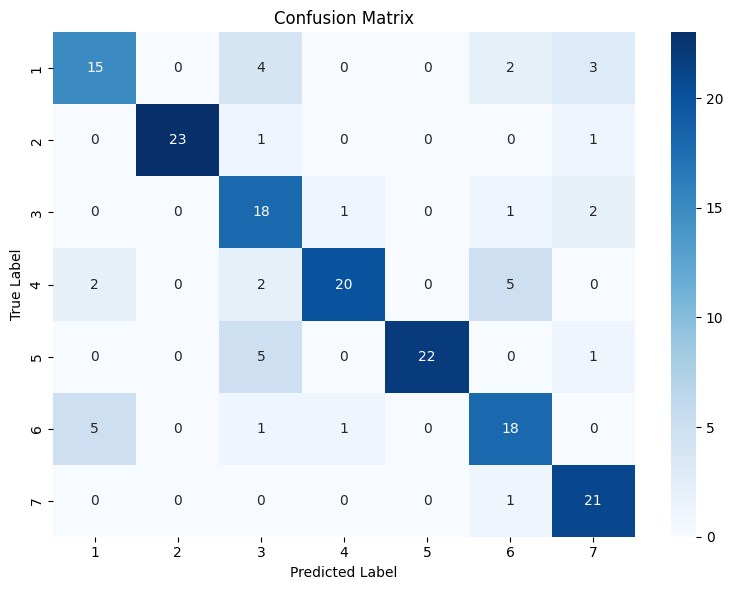

In [7]:
# Predict pada test set
y_pred = knn_model.predict(X_test)

# Hitung akurasi
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Test Accuracy: {accuracy*100:.2f}%\n")

# Classification Report
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred, 
                          target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### 1.5 Model Serialization (Save Model)

In [8]:
# Simpan model dan encoder
os.makedirs('models', exist_ok=True)

joblib.dump(knn_model, 'models/knn_fish_classifier.pkl')
joblib.dump(label_encoder, 'models/label_encoder.pkl')

# Simpan metadata
metadata = {
    'n_features': N_FEATURES,
    'classes': label_encoder.classes_.tolist(),
    'accuracy': float(accuracy)
}

import json
with open('models/model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

print("✓ Model saved successfully!")
print(f"  - Model: models/knn_fish_classifier.pkl")
print(f"  - Encoder: models/label_encoder.pkl")
print(f"  - Metadata: models/model_metadata.json")
print(f"\nKey Info:")
print(f"  - Feature dimension (N): {N_FEATURES}")
print(f"  - Number of classes: {len(label_encoder.classes_)}")

✓ Model saved successfully!
  - Model: models/knn_fish_classifier.pkl
  - Encoder: models/label_encoder.pkl
  - Metadata: models/model_metadata.json

Key Info:
  - Feature dimension (N): 463
  - Number of classes: 7


---
## FASE 2: Image Processing Pipeline ("The Bridge")
### 2.1 Preprocessing & Segmentation

In [9]:
def preprocess_and_segment(image):
    """
    Step 1: Preprocessing dan Binary Segmentation
    
    Args:
        image: Input image (BGR dari cv2.imread atau RGB dari upload)
    
    Returns:
        binary_mask: Binary image (255=ikan, 0=background)
    """
    # Convert ke grayscale jika belum
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    # Otsu Thresholding untuk segmentasi otomatis
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Morphological operations untuk bersihkan noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    binary_clean = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    binary_clean = cv2.morphologyEx(binary_clean, cv2.MORPH_OPEN, kernel)
    
    return binary_clean

# Test dengan gambar dummy
print("✓ Preprocessing function created")

✓ Preprocessing function created


### 2.2 Contour Extraction & Resampling

In [10]:
def extract_and_resample_contour(binary_mask, n_points):
    """
    Step 2: Extract kontur terbesar dan resample ke N titik
    
    Args:
        binary_mask: Binary image dari preprocessing
        n_points: Jumlah titik yang diinginkan (harus = N_FEATURES dari training)
    
    Returns:
        contour_resampled: Array (n_points, 2) koordinat [x, y]
    """
    # Cari kontur
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    if len(contours) == 0:
        raise ValueError("Tidak ada kontur ditemukan di gambar")
    
    # Ambil kontur terbesar (asumsi = objek ikan)
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Konversi ke array 2D (N_original_points, 2)
    contour_points = largest_contour.squeeze()
    
    if contour_points.ndim == 1:
        # Jika hanya 1 titik, tidak bisa diproses
        raise ValueError("Kontur terlalu kecil")
    
    # Resample menggunakan interpolasi
    # Buat parameter t dari 0 ke 1
    n_original = len(contour_points)
    t_original = np.linspace(0, 1, n_original)
    t_new = np.linspace(0, 1, n_points)
    
    # Interpolasi untuk x dan y secara terpisah
    fx = interpolate.interp1d(t_original, contour_points[:, 0], kind='linear')
    fy = interpolate.interp1d(t_original, contour_points[:, 1], kind='linear')
    
    x_resampled = fx(t_new)
    y_resampled = fy(t_new)
    
    contour_resampled = np.column_stack([x_resampled, y_resampled])
    
    return contour_resampled

print("✓ Contour extraction function created")

✓ Contour extraction function created


### 2.3 Feature Conversion (Time Series Generation)

In [11]:
def contour_to_timeseries(contour_points, method='centroid_distance'):
    """
    Step 3: Konversi koordinat kontur menjadi time series signal
    
    Args:
        contour_points: Array (N, 2) koordinat [x, y]
        method: 'centroid_distance' atau 'turn_angle'
    
    Returns:
        time_series: Array 1D (N,) yang sudah dinormalisasi
    """
    if method == 'centroid_distance':
        # Metode 1: Jarak Euclidean dari centroid ke setiap titik kontur
        centroid_x = np.mean(contour_points[:, 0])
        centroid_y = np.mean(contour_points[:, 1])
        
        distances = np.sqrt((contour_points[:, 0] - centroid_x)**2 + 
                          (contour_points[:, 1] - centroid_y)**2)
        time_series = distances
        
    elif method == 'turn_angle':
        # Metode 2: Turn Angle (sudut belokan) di setiap titik
        angles = []
        n = len(contour_points)
        
        for i in range(n):
            p_prev = contour_points[i - 1]
            p_curr = contour_points[i]
            p_next = contour_points[(i + 1) % n]
            
            # Vektor dari prev ke curr
            v1 = p_curr - p_prev
            # Vektor dari curr ke next
            v2 = p_next - p_curr
            
            # Hitung sudut antara kedua vektor
            angle = np.arctan2(v2[1], v2[0]) - np.arctan2(v1[1], v1[0])
            angles.append(angle)
        
        time_series = np.array(angles)
    
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Normalisasi ke [0, 1] menggunakan MinMaxScaler
    scaler = MinMaxScaler()
    time_series_normalized = scaler.fit_transform(time_series.reshape(-1, 1)).flatten()
    
    # Scaling ke range yang sama dengan training data (lihat data .arff: range ~-1 to 2)
    # Ubah dari [0,1] ke [-1, 2]
    time_series_scaled = time_series_normalized * 3 - 1
    
    return time_series_scaled

print("✓ Time series conversion function created")

✓ Time series conversion function created


### 2.4 End-to-End Pipeline: Image → Time Series

In [12]:
def image_to_features(image_path, n_features, method='centroid_distance', visualize=False):
    """
    PIPELINE UTAMA: Gambar Mentah → Array Fitur untuk Model
    
    Args:
        image_path: Path ke gambar atau array image
        n_features: Dimensi fitur yang diperlukan (dari training)
        method: Metode konversi time series
        visualize: Tampilkan hasil intermediate steps
    
    Returns:
        features: Array 1D (n_features,) siap untuk prediksi
    """
    # Load image
    if isinstance(image_path, str):
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Cannot read image: {image_path}")
    else:
        image = image_path
    
    # Step 1: Preprocessing & Segmentation
    binary_mask = preprocess_and_segment(image)
    
    # Step 2: Extract & Resample Contour
    contour_resampled = extract_and_resample_contour(binary_mask, n_features)
    
    # Step 3: Convert to Time Series
    time_series = contour_to_timeseries(contour_resampled, method=method)
    
    # Visualisasi (optional)
    if visualize:
        fig, axes = plt.subplots(1, 4, figsize=(16, 4))
        
        # Original image
        if len(image.shape) == 3:
            axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        else:
            axes[0].imshow(image, cmap='gray')
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        
        # Binary mask
        axes[1].imshow(binary_mask, cmap='gray')
        axes[1].set_title('Binary Segmentation')
        axes[1].axis('off')
        
        # Resampled contour
        axes[2].plot(contour_resampled[:, 0], contour_resampled[:, 1], 'b.-', markersize=2)
        axes[2].set_title(f'Contour ({n_features} points)')
        axes[2].invert_yaxis()
        axes[2].axis('equal')
        
        # Time series signal
        axes[3].plot(time_series)
        axes[3].set_title(f'Time Series Signal ({method})')
        axes[3].set_xlabel('Point Index')
        axes[3].set_ylabel('Value')
        axes[3].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return time_series

print("✓ End-to-end pipeline function created")

✓ End-to-end pipeline function created


---
## FASE 3: Testing Pipeline dengan Gambar Dummy

Testing pipeline dengan gambar dummy...



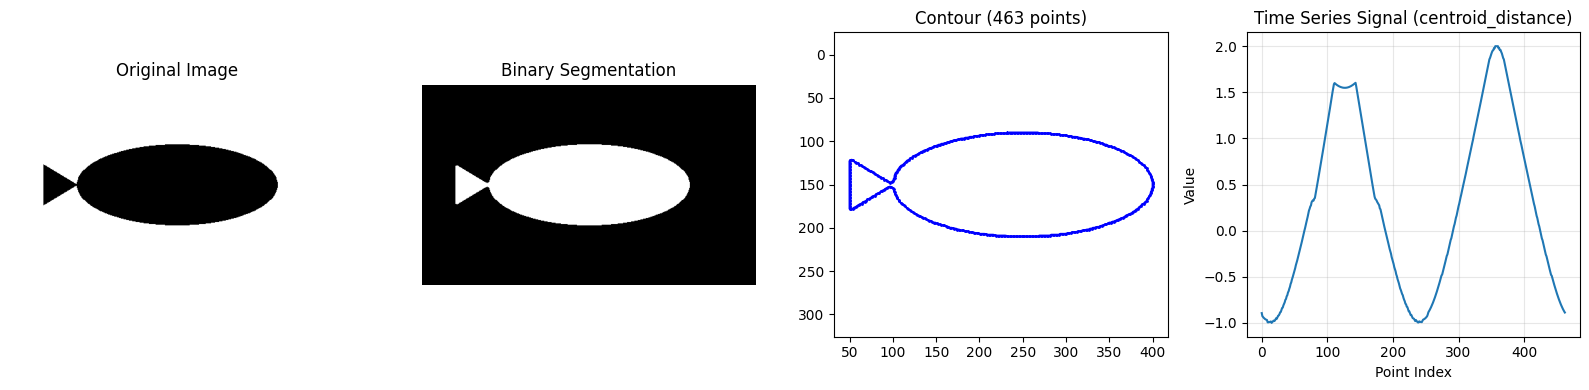


✓ Pipeline berhasil!
  Input: Image (300x500)
  Output: Feature array shape = (463,)
  Feature range: [-1.00, 2.00]


In [13]:
# Buat gambar dummy berbentuk ikan sederhana untuk testing
def create_dummy_fish_image():
    """Buat gambar dummy ikan untuk testing"""
    img = np.ones((300, 500), dtype=np.uint8) * 255  # Background putih
    
    # Gambar bentuk ikan sederhana (ellipse)
    center = (250, 150)
    axes = (150, 60)  # (width/2, height/2)
    cv2.ellipse(img, center, axes, 0, 0, 360, 0, -1)  # Hitam
    
    # Tambah ekor
    pts = np.array([[100, 150], [50, 120], [50, 180]], np.int32)
    cv2.fillPoly(img, [pts], 0)
    
    return img

# Generate dummy fish
dummy_fish = create_dummy_fish_image()

# Test pipeline
print("Testing pipeline dengan gambar dummy...\n")
features = image_to_features(dummy_fish, N_FEATURES, visualize=True)

print(f"\n✓ Pipeline berhasil!")
print(f"  Input: Image (300x500)")
print(f"  Output: Feature array shape = {features.shape}")
print(f"  Feature range: [{features.min():.2f}, {features.max():.2f}]")

### Test Prediction dengan Dummy Image

In [14]:
# Test prediksi
features_reshaped = features.reshape(1, -1)  # Model butuh shape (1, n_features)
prediction = knn_model.predict(features_reshaped)
predicted_class = label_encoder.inverse_transform(prediction)[0]

print(f"Predicted Class: {predicted_class}")
print(f"(Note: Ini adalah dummy image, jadi prediksi mungkin random)")

Predicted Class: 1
(Note: Ini adalah dummy image, jadi prediksi mungkin random)


---
## 🚀 DEPLOYMENT: Streamlit Application

Aplikasi Streamlit sudah dibuat di file `streamlit_app.py`

### Cara Menjalankan:

1. **Install dependencies** (jika belum):
```bash
pip install streamlit opencv-python scikit-learn joblib scipy matplotlib pillow
```

2. **Jalankan aplikasi**:
```bash
streamlit run streamlit_app.py
```

3. **Upload gambar ikan** di browser yang terbuka

### Fitur Aplikasi:
- ✅ Upload gambar
- ✅ Visualisasi pipeline processing
- ✅ Prediksi spesies real-time
- ✅ Pilihan metode feature extraction
- ✅ Informasi model dan metrics

---
## 📚 Ringkasan Workflow

### FASE 1: Training Model ✅
- ✅ Parse data .arff (Fish_TRAIN.arff, Fish_TEST.arff)
- ✅ Label encoding
- ✅ Train KNN model (k=1, euclidean distance)
- ✅ Evaluasi (accuracy, confusion matrix)
- ✅ Simpan model + encoder + metadata

### FASE 2: Image Processing Pipeline ✅
- ✅ **Preprocessing**: Grayscale → Otsu Thresholding → Morphological Ops
- ✅ **Contour Extraction**: Find contours → Ambil terbesar
- ✅ **Resampling**: Interpolate ke N=463 titik
- ✅ **Feature Conversion**: Centroid Distance / Turn Angle → Normalisasi

### FASE 3: Deployment ✅
- ✅ Streamlit application (`streamlit_app.py`)
- ✅ Upload gambar → Real-time prediction
- ✅ Visualisasi pipeline steps

---

## 🎯 Key Takeaways

1. **Data Dimension Critical**: N=463 fitur harus konsisten antara training dan inference
2. **Normalization Matters**: Range data harus sama [-1, 2]
3. **Contour Quality**: Segmentasi yang baik = prediksi akurat
4. **Distance Metric**: Euclidean distance cocok untuk time series shape matching

## 🔧 Next Steps (Optional)

- Tambahkan data augmentation untuk training
- Eksperimen dengan k > 1
- Coba algoritma lain (Random Forest, SVM)
- Deploy ke cloud (Streamlit Cloud, Hugging Face Spaces)